<b> Step 1: Load the EEG Data </b>

In [1]:
import mne
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

# Load the subject information
subject_info = pd.read_csv('subject-info.csv')
print(subject_info.head())

# Find all the EDF files
all_file_path = glob('eeg-during-mental-arithmetic-tasks-1.0.0/*.edf')
print(len(all_file_path))

# Separate rest and task files
rest_file_path = [i for i in all_file_path if '_1' in os.path.basename(i)]
task_file_path = [i for i in all_file_path if '_2' in os.path.basename(i)]
print(len(rest_file_path), len(task_file_path))

# Load one rest file and one task file as examples
rest_data = mne.io.read_raw_edf(rest_file_path[0], preload=True)
task_data = mne.io.read_raw_edf(task_file_path[0], preload=True)

# Print basic information about the loaded data
print(rest_data.info)
print(task_data.info)


     Subject  Age Gender  Recording year  Number of subtractions  \
0  Subject00   21      F            2011                    9.70   
1  Subject01   18      F            2011                   29.35   
2  Subject02   19      F            2012                   12.88   
3  Subject03   17      F            2010                   31.00   
4  Subject04   17      F            2010                    8.60   

   Count quality  
0              0  
1              1  
2              1  
3              1  
4              0  
72
36 36
Extracting EDF parameters from D:\IIT Roorkee Internship\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from D:\IIT Roorkee Internship\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ..

<b>Step 2: Power Spectral Density (PSD) Analysis</b>

a. Calculate the band-wise PSD
We'll calculate the band-wise PSD for both rest and task states focusing on the following frequency bands: Delta (1-4 Hz), Theta (4-8 Hz), Alpha (8-12 Hz), Beta (12-30 Hz), and Gamma (30-100 Hz).

In [2]:
# Define frequency bands
bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 100)}

# Function to calculate PSD for a given frequency band
def calculate_psd(data, sfreq):
    psds, freqs = mne.time_frequency.psd_array_welch(data, sfreq=sfreq, fmin=1, fmax=100, n_fft=2048)
    return psds, freqs

# Extract data and sampling frequency
rest_data_array = rest_data.get_data()
task_data_array = task_data.get_data()
sfreq = rest_data.info['sfreq']

# Calculate PSD for both rest and task data
rest_psd, rest_freqs = calculate_psd(rest_data_array, sfreq)
task_psd, task_freqs = calculate_psd(task_data_array, sfreq)

# Average the PSD values over the specified frequency bands
def average_psd_over_bands(psds, freqs, bands):
    band_psds = {}
    for band, (fmin, fmax) in bands.items():
        freq_mask = (freqs >= fmin) & (freqs <= fmax)
        band_psds[band] = np.mean(psds[:, freq_mask], axis=1)
    return band_psds

psd_rest = average_psd_over_bands(rest_psd, rest_freqs, bands)
psd_task = average_psd_over_bands(task_psd, task_freqs, bands)


Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


b. Compare the PSDs and summarize the findings
We can plot the PSDs for visual comparison.

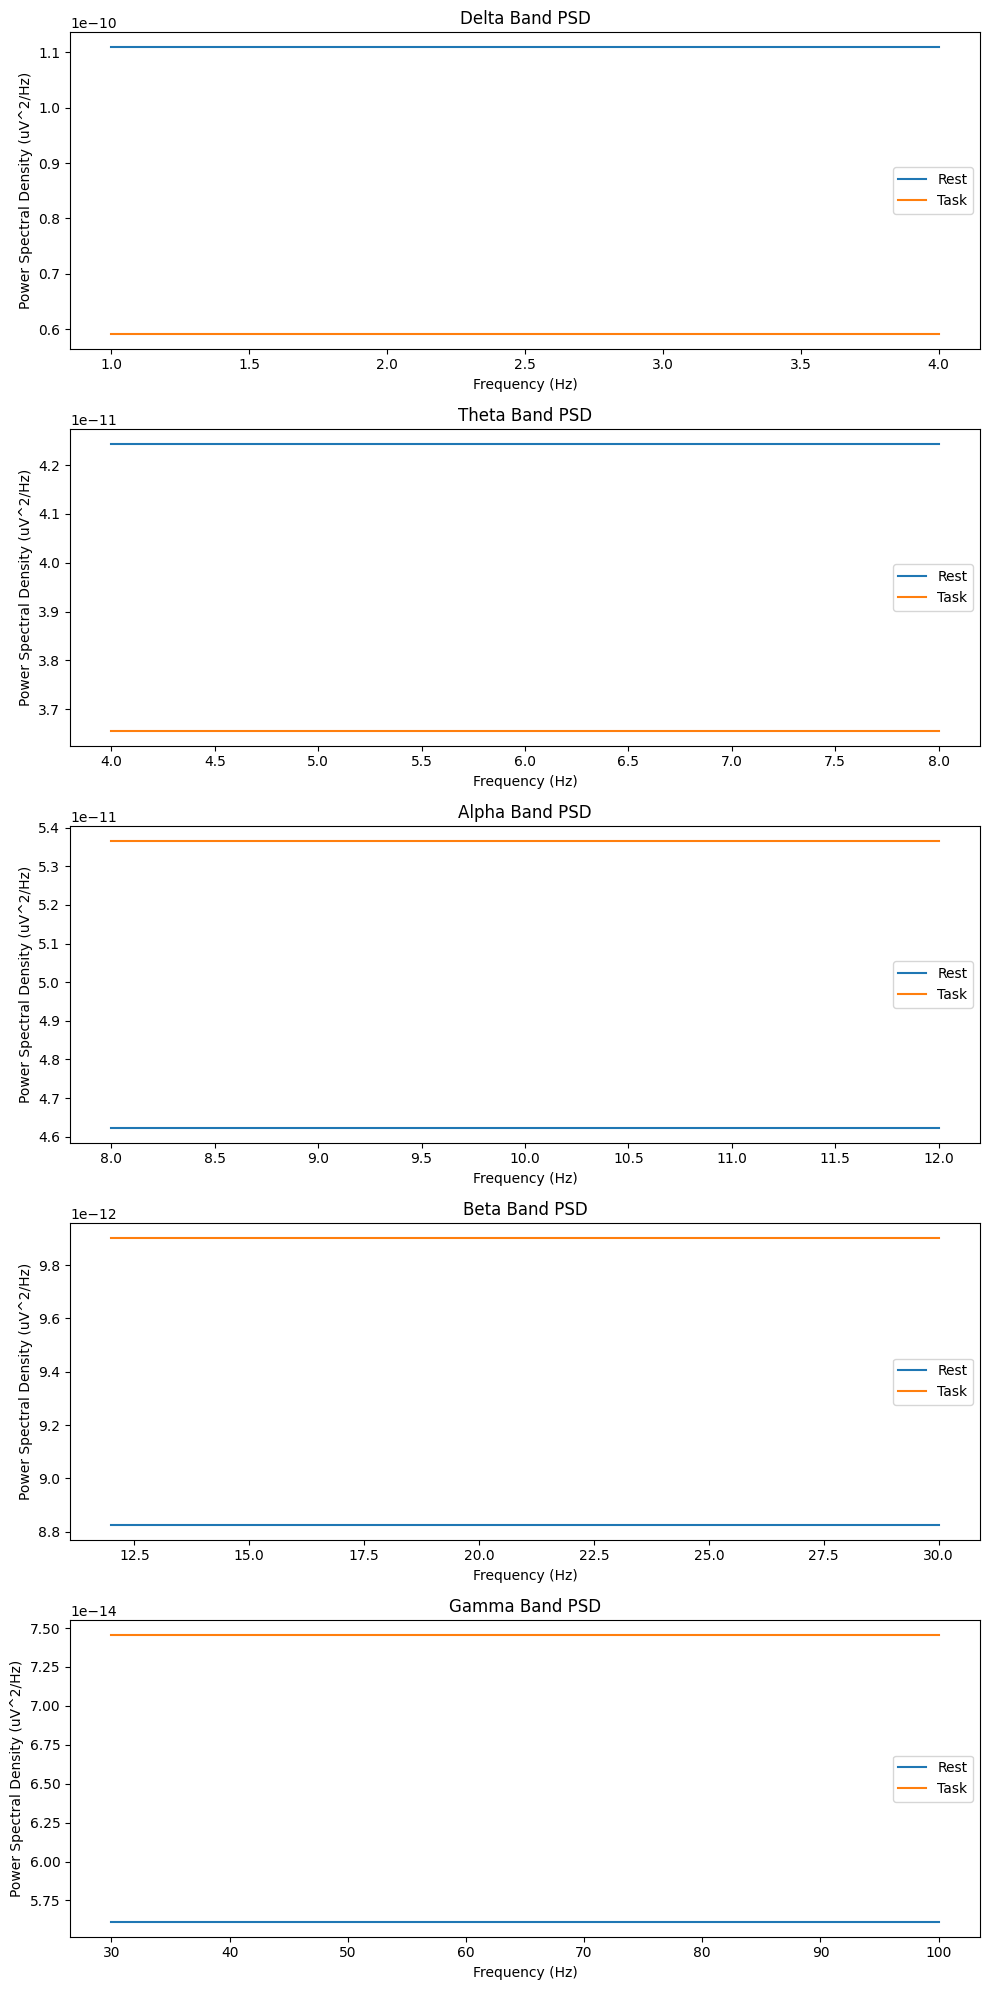

In [3]:
# Plot the PSD for each frequency band
fig, axes = plt.subplots(len(bands), 1, figsize=(10, 20))

for i, band in enumerate(bands.keys()):
    ax = axes[i]
    rest_psd = psd_rest[band]
    task_psd = psd_task[band]
    
    # Plot mean PSD for each band
    ax.plot([bands[band][0], bands[band][1]], [np.mean(rest_psd)]*2, label='Rest')
    ax.plot([bands[band][0], bands[band][1]], [np.mean(task_psd)]*2, label='Task')
    ax.set_title(f'{band} Band PSD')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density (uV^2/Hz)')
    ax.legend()

plt.tight_layout()
plt.show()

<b>Step 3: Deep Learning Classification</b>

We'll extract relevant features from the cleaned data and implement binary classification using two different deep learning models.

a. Extract relevant features
We need to extract relevant features from the EEG data. This can include mean, standard deviation, and other statistical measures of the PSDs.

In [4]:
import pandas as pd

# Function to extract features from the PSD data
def extract_features(psd_dict):
    features = {}
    for band, psd in psd_dict.items():
        mean_psd = np.mean(psd)
        std_psd = np.std(psd)
        features[f'{band}_mean'] = mean_psd
        features[f'{band}_std'] = std_psd
    return pd.DataFrame(features, index=[0])

# Extract features for rest and task data
features_rest = extract_features(psd_rest)
features_task = extract_features(psd_task)

 # Add labels
features_rest['label'] = 0  # Rest state
features_task['label'] = 1  # Task state

# Combine the data
features_combined = pd.concat([features_rest, features_task], ignore_index=True)

b. Implement binary classification using deep learning models
We'll implement EEGNet and TSCeption as examples.

<b> EEGNet </b>

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
import pandas as pd
import sys
sys.setrecursionlimit(3000)

In [6]:
# Example data for testing purposes
features = pd.DataFrame({
    'feature1': np.random.rand(100),
    'feature2': np.random.rand(100),
    'label': np.random.randint(0, 2, 100)
})

# Prepare the data
X = features.drop(columns=['label']).values
y = features['label'].values
X = X.reshape((X.shape[0], X.shape[1], 1, 1))  # Reshape for Conv2D
print(X.shape)
               
model_eegnet = Sequential([
    Conv2D(16, (1, 1), activation='relu', input_shape=(X.shape[1], 1, 1)),
    MaxPooling2D((1, 1)),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_eegnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_eegnet.summary()

(100, 2, 1, 1)


C:\Users\ASHISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 2, 1, 16)            │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2, 1, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 1, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,209 (8.63 KB)

 Trainable params: 2,209 (8.63 KB)

 Non-trainable params: 0 (0.00 B)

Train the EEGNet model

In [7]:
model_eegnet.fit(X, y, epochs=50, batch_size=8, validation_split=0.2)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5434 - loss: 0.6879 - val_accuracy: 0.4500 - val_loss: 0.7015
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4988 - loss: 0.7024 - val_accuracy: 0.4500 - val_loss: 0.7001
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5192 - loss: 0.7222 - val_accuracy: 0.4500 - val_loss: 0.6991
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4655 - loss: 0.7039 - val_accuracy: 0.4500 - val_loss: 0.6980
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5134 - loss: 0.7217 - val_accuracy: 0.5000 - val_loss: 0.6983
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4301 - loss: 0.7193 - val_accuracy: 0.5000 - val_loss: 0.6981
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4784 - loss: 0.7076 - val_accuracy: 0.5000 - val_loss: 0.6977
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5779 - loss: 0.6793 - val_accuracy: 0.5000 - val_loss

c. Train and validate the models
We'll split the data into training and testing sets.

In [8]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model_eegnet.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4885 - loss: 0.7057 - val_accuracy: 0.5500 - val_loss: 0.6892
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5784 - loss: 0.6847 - val_accuracy: 0.5500 - val_loss: 0.6888
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5732 - loss: 0.6920 - val_accuracy: 0.5500 - val_loss: 0.6883
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5499 - loss: 0.6972 - val_accuracy: 0.6000 - val_loss: 0.6875
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6407 - loss: 0.6800 - val_accuracy: 0.6000 - val_loss: 0.6875
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5175 - loss: 0.7035 - val_accuracy: 0.6000 - val_loss: 0.6876
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3757 - loss: 0.7121 - val_accuracy: 0.7000 - val_loss: 0.6879
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4647 - loss: 0.7139 - val_accuracy: 0.7500 - val_loss

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
y_pred = (model_eegnet.predict(X_test) > 0.5).astype("int32")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Accuracy: 0.6
Precision: 0.5714285714285714
Recall: 0.8
F1-Score: 0.6666666666666666


<b> TSCeption </b>

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Concatenate, AveragePooling2D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Sample data for testing purposes
np.random.seed(42)
num_samples = 100
num_timesteps = 10
num_features = 2

# Create features and labels with consistent lengths
features = np.random.rand(num_samples, num_timesteps, num_features)
labels = np.random.randint(0, 2, num_samples)

# Prepare the data
X = features
y = labels

# Print the shape of X to understand its dimensions
print("Original shape of X:", X.shape)

# Reshape X to (num_samples, num_timesteps, num_features, 1)
X = X.reshape((num_samples, num_timesteps, num_features, 1))

# Convert labels to categorical
y = tf.keras.utils.to_categorical(y, num_classes=2)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the TSCeption model
class TSCeption:
    def __init__(self, input_shape, nb_classes, conv_filters=16, kernel_size=5, dropout_rate=0.5):
        self.input_shape = input_shape
        self.nb_classes = nb_classes
        self.conv_filters = conv_filters
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate

    def build_model(self):
        inputs = Input(shape=self.input_shape)

        # Temporal Convolutional Layers
        conv1 = Conv2D(self.conv_filters, (1, self.kernel_size), padding='same', activation='relu')(inputs)
        conv2 = Conv2D(self.conv_filters, (1, self.kernel_size), padding='same', activation='relu')(conv1)
        conv3 = Conv2D(self.conv_filters, (1, self.kernel_size), padding='same', activation='relu')(conv2)

        # Spatial Convolutional Layers
        conv4 = Conv2D(self.conv_filters, (self.kernel_size, 1), padding='same', activation='relu')(conv3)
        conv5 = Conv2D(self.conv_filters, (self.kernel_size, 1), padding='same', activation='relu')(conv4)
        conv6 = Conv2D(self.conv_filters, (self.kernel_size, 1), padding='same', activation='relu')(conv5)

        # Concatenate all the convolutional layers
        concatenated = Concatenate()([conv3, conv6])

        # Further processing
        pooled = AveragePooling2D((2, 2))(concatenated)
        flattened = Flatten()(pooled)
        dense1 = Dense(128, activation='relu')(flattened)
        drop1 = Dropout(self.dropout_rate)(dense1)
        outputs = Dense(self.nb_classes, activation='softmax')(drop1)

        model = Model(inputs=inputs, outputs=outputs)
        return model

# Create and compile the TSCeption model
tsception = TSCeption(input_shape=(num_timesteps, num_features, 1), nb_classes=2)
model_tsception = tsception.build_model()
model_tsception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_tsception.summary()

Original shape of X: (100, 10, 2)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 10, 2, 1)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 10, 2, 16)         │              96 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 10, 2, 16)         │           1,296 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 10, 2, 16)         │           1,296 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 10, 2, 16)         │           1,296 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 10, 2, 16)         │           1,296 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 10, 2, 16)         │           1,296 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 10, 2, 32)         │               0 │ conv2d_3[0][0],            │
│                               │                           │                 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d             │ (None, 5, 1, 32)          │               0 │ concatenate[0][0]          │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 160)               │               0 │ average_pooling2d[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │          20,608 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 2)                 │             258 │ dropout_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 27,442 (107.20 KB)

 Trainable params: 27,442 (107.20 KB)

 Non-trainable params: 0 (0.00 B)

Training and Testing

In [11]:
# Train the model
model_tsception.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.2)

# Make predictions on the test set
y_pred_prob = model_tsception.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.4223 - loss: 0.6951 - val_accuracy: 0.3125 - val_loss: 0.6950
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5327 - loss: 0.6931 - val_accuracy: 0.3125 - val_loss: 0.6999
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6223 - loss: 0.6873 - val_accuracy: 0.3125 - val_loss: 0.7079
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5697 - loss: 0.6911 - val_accuracy: 0.3125 - val_loss: 0.7132
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5879 - loss: 0.6879 - val_accuracy: 0.3125 - val_loss: 0.7198
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5552 - loss: 0.6850 - val_accuracy: 0.3125 - val_loss: 0.7314
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6357 - loss: 0.6683 - val_accuracy: 0.3125 - val_loss: 0.7499
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5718 - loss: 0.6849 - val_accuracy: 0.3125 - val_loss: 0.7439


In [12]:
# Calculate the metrics
accuracy = accuracy_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred)
recall = recall_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6000
Precision: 0.5000
Recall: 0.5000
F1 Score: 0.5000
